# Cell-type count classifier baseline (CTCC)

### Performance (logreg)

On Wang labels, including outliers etc
```
Mean test  acc: 0.5843 +/- 0.0274
Mean test prec: 0.6445 +/- 0.0254
Mean test  rec: 0.6554 +/- 0.0287
Mean test   f1: 0.6460 +/- 0.0241
Mean test  auc: 0.5698 +/- 0.0290
```

Without all the outliers: (basically the same...)
```
Mean test  acc: 0.5869 +/- 0.0285
Mean test prec: 0.6305 +/- 0.0278
Mean test  rec: 0.6483 +/- 0.0345
Mean test   f1: 0.6345 +/- 0.0276
Mean test  auc: 0.5786 +/- 0.0293
```

With LASSO regression (a=0.03):
```
Mean test  acc: 0.6303 +/- 0.0270
Mean test prec: 0.6592 +/- 0.0264
Mean test  rec: 0.7208 +/- 0.0313
Mean test   f1: 0.6838 +/- 0.0236
Mean test  auc: 0.6181 +/- 0.0281
```

Same LASSO but without log-transforming
```
Mean test  acc: 0.6411 +/- 0.0293
Mean test prec: 0.6598 +/- 0.0242
Mean test  rec: 0.7567 +/- 0.0360
Mean test   f1: 0.7008 +/- 0.0260
Mean test  auc: 0.6250 +/- 0.0296
```


In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from tqdm import tqdm, trange

sns.set_style("darkgrid")

In [2]:
# Settings
LABEL = "wang"

In [3]:
adata = ad.read_h5ad("data/ctcc/ct_counts.h5ad")

DONORS = ['10100574', '10100862', '10202345', '10205244', '10249336', '10253148', '10263208', '10271474', '10277308', '10288185', '10290427', '10291856', '10292311', '10298957', '10315029', '10383017', '10394182', '10405008', '10435090', '10436131', '10438999', '10460587', '10473384', '10484873', '10490993', '10502798', '10510090', '10516762', '10518782', '10551157', '10557081', '10577337', '10669174', '10684501', '10866165', '10901987', '10929637', '11157783', '11165535', '11173549', '11259716', '11310844', '11327005', '11331231', '11349119', '11371707', '11392518', '11395417', '11413170', '11430815', '11444465', '11453772', '11460357', '11467746', '11469504', '11471260', '11606935', '11612505', '11615242', '11616707', '11619606', '11630705', '11632851', '11652071', '11681508', '11697592', '1211411', '12365619', '14184286', '14498577', '15113169', '15121461', '15161351', '15176592', '15218541', '15413198', '15420223', '15483818', '15495024', '15738428', '15844425', '16068769', '17929065', '18414513', '18659212', '18920002', '20124321', '20139562', '20139850', '20151388', '20156469', '20195344', '20201189', '20201927', '20205705', '20207013', '20223617', '20244554', '20254588', '20254876', '20254902', '20263921', '20288196', '20311676', '20344143', '20376029', '20399274', '20416210', '20455807', '20500815', '20504017', '20521752', '20532115', '20561642', '20569910', '20584923', '20594407', '20611993', '20630946', '20646778', '20674902', '20682204', '20726273', '20767628', '20774339', '20779834', '20780035', '20798913', '20834164', '20875195', '20892128', '20898476', '20904509', '20906079', '20907534', '20929774', '20939708', '20942767', '20956605', '20963578', '20970441', '20974481', '20976799', '20993308', '20996621', '20998065', '21001519', '21001771', '21001933', '21002524', '21101658', '21112011', '21156815', '21171080', '21191200', '21193068', '21272396', '21362537', '21401399', '21402016', '21406920', '21411323', '22776575', '22789958', '22868024', '23004922', '23690880', '24039289', '24680888', '24747976', '26631069', '29933130', '31509843', '31726180', '31908032', '32383679', '33501827', '34726040', '34779151', '34962204', '35941263', '36492755', '37030589', '37065652', '3713990', '37178462', '37436329', '37527863', '3889845', '39484737', '39989287', '41285665', '41773404', '43074402', '43485807', '44019405', '44671043', '45115248', '45566083', '46000440', '46246604', '46251007', '48023497', '50100806', '50100932', '50101659', '50102088', '50102376', '50104008', '50104134', '50105301', '50105699', '50106280', '50106442', '50106730', '50107619', '50107745', '50107907', '50108912', '50109477', '50109639', '50109927', '50197261', '50300084', '50300408', '50300822', '50301099', '50301125', '50301675', '50301963', '50302004', '50302266', '50302554', '50400259', '50400385', '50400709', '50400835', '50401002', '50402567', '50402693', '50402729', '50403446', '50404299', '50405042', '50405330', '50406057', '50410319', '50500136', '50500550', '51520126', '51624179', '51815338', '51826377', '52764842', '52940446', '53772202', '54324848', '57978756', '60725338', '60747316', '60848460', '61029627', '61142759', '61344957', '61827429', '62404688', '62483327', '63188799', '64493027', '65001607', '65652206', '65736039', '66406040', '66754397', '66924745', '67185070', '67429065', '68015667', '6804844', '68525196', '68539908', '68745332', '69982533', '70153803', '70625336', '70816595', '70883578', '70917649', '71626373', '7253015', '72650337', '7265221', '72777797', '7311370', '74284255', '74753465', '75990666', '76733461', '76867532', '77143621', '77239958', '77891596', '78353027', '78452313', '80790863', '81086436', '8109170', '82317494', '82684406', '83034844', '83173570', '84417209', '84642424', '85065193', '85171938', '86408244', '86934089', '87645445', '87779516', '89164957', '89546375', '89903942', '90267190', '90780976', '90942860', '91018909', '91444029', '91707643', '92393245', '92629514', '93815598', '94092977', '94144536', '94430339', '95491648', '95919181', '96095092', '9841821', '98953007']
CELLTYPES = adata.var_names.values

adata = adata[adata.obs_names.isin(DONORS)].copy()
adata

AnnData object with n_obs × n_vars = 339 × 54
    obs: 'n_cells', 'n_celltypes', 'projid', 'Supertype', 'Donor ID', 'study', 'scaled_to', 'agreeableness', 'conscientiousness', 'extraversion_6', 'neo_altruism', 'neo_trust', 'neuroticism_12', 'openness', 'neuroticism_48', 'neuroticism_6', 'apoe_genotype', 'clin_dlb', 'cogdx', 'cogdx_stroke', 'dxpark', 'cogn_ep_lv', 'cogn_po_lv', 'cogn_ps_lv', 'cogn_se_lv', 'cogn_wo_lv', 'cognep_random_slope', 'cogng_random_slope', 'cognpo_random_slope', 'cognps_random_slope', 'cognse_random_slope', 'cognwo_random_slope', 'cogn_global_lv', 'age_bl', 'age_death', 'educ', 'msex', 'race', 'spanish', 'agefirst', 'agelast', 'menoage', 'mensage', 'natura', 'othspe00', 'whatwas', 'alcohol_g_bl', 'ldai_bl', 'q3smo_bl', 'q4smo_bl', 'smoking', 'chd_cogact_freq', 'lifetime_cogact_freq_bl', 'ma_adult_cogact_freq', 'ya_adult_cogact_freq', 'phys5itemsum_bl', 'phys5itemsum_lv', 'soc_net_bl', 'social_isolation_avg', 'social_isolation_lv', 'hypertension_bl', 'cancer_bl', 

In [4]:
if LABEL == "wang":
    # make the wang labels
    wang_labels = []
    for i in range(adata.shape[0]):
        cogdx = adata[i].obs["cogdx"].values[0]
        braaksc = adata[i].obs["braaksc"].values[0]
        ceradsc = adata[i].obs["ceradsc"].values[0]
        if cogdx == 4 and braaksc >= 4 and ceradsc <= 2:
            wang_labels.append("AD")
        elif cogdx == 1 and braaksc <= 3 and ceradsc >= 3:
            wang_labels.append("CT")
        else:
            wang_labels.append("Other")

    adata.obs["Label"] = np.array(wang_labels)
    adata = adata[adata.obs["Label"] != "Other"].copy()
    
elif LABEL == "reagan" or LABEL == "raegan-no-intermediate":
    adata.obs["Label"] = adata.obs["niareagansc"].map({1: "AD", 2: "AD", 3: "CT", 4: "CT"})
    if LABEL == "raegan-no-intermediate":
        adata = adata[adata.obs["niareagansc"] != 2].copy()
        
elif LABEL == "cogdx":
    adata.obs["Label"] = adata.obs["cogdx"].map({1: "CT", 4: "AD"})
    adata = adata[adata.obs["Label"].isin(["CT", "AD"])].copy()
    
adata.obs["y"] = adata.obs["Label"].map({"AD": 1, "CT": 0})

# class balance:
print(adata.obs["Label"].value_counts())
print(adata.obs["Label"].value_counts(normalize=True))

Label
AD    78
CT    61
Name: count, dtype: int64
Label
AD    0.561151
CT    0.438849
Name: proportion, dtype: float64


In [5]:
X = adata.X
Y = adata.obs["y"].values

# counts per 10k
X = X / X.sum(axis=1)[:, None] * 1e4

# log1p
# X = np.log1p(X)

# standardize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [6]:
# Split by class
X_ct = X[Y == 0]
X_ad = X[Y == 1]
Y_ct = Y[Y == 0]
Y_ad = Y[Y == 1]

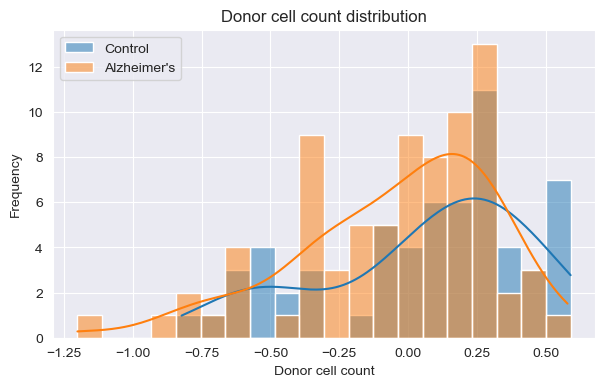

In [7]:
bins = np.histogram_bin_edges(X.mean(axis=1), bins=20)

fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(X_ct.mean(axis=1), bins=bins, kde=True, label="Control", ax=ax)
sns.histplot(X_ad.mean(axis=1), bins=bins, kde=True, label="Alzheimer's", ax=ax)
plt.title("Donor cell count distribution")
plt.xlabel("Donor cell count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

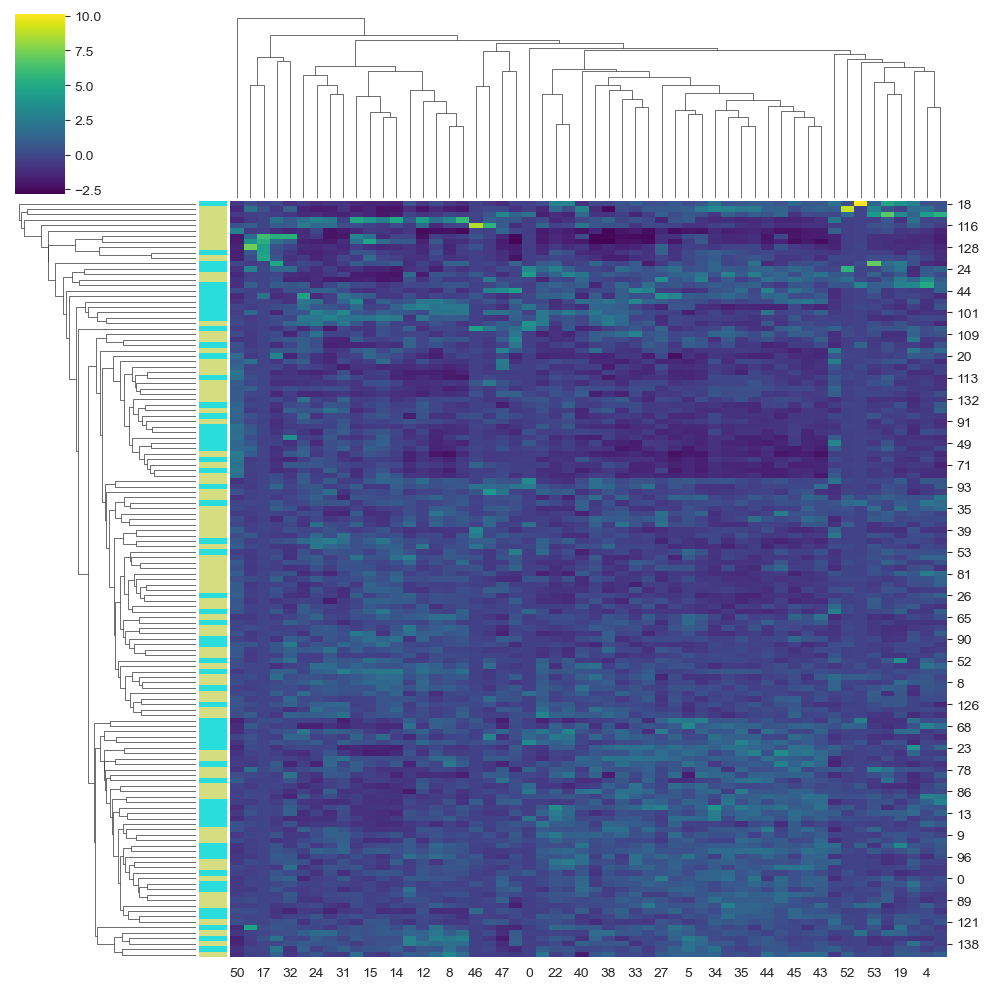

In [8]:
colors = sns.color_palette("rainbow", 2)
color_vals = adata.obs["Label"].values
row_colors = pd.Series(color_vals).map({"CT": colors[0], "AD": colors[1]}).values
sns.clustermap(X, cmap="viridis", figsize=(10, 10), row_colors=row_colors)
plt.show()

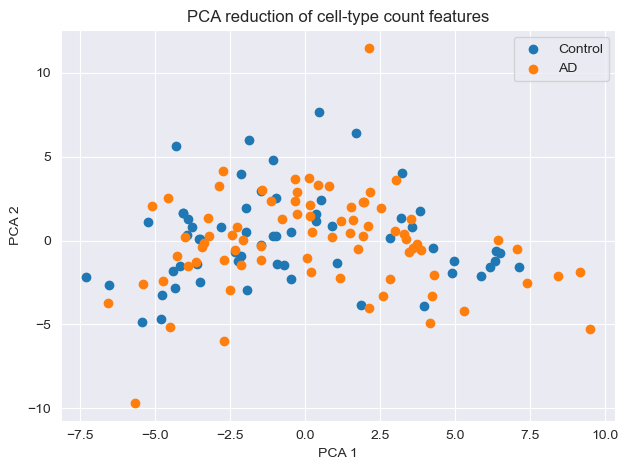

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[Y == 0, 0], X_pca[Y == 0, 1], label="Control")
plt.scatter(X_pca[Y == 1, 0], X_pca[Y == 1, 1], label="AD")
plt.title("PCA reduction of cell-type count features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.tight_layout()
plt.show()

c:\Users\timo\.conda\envs\pyg\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


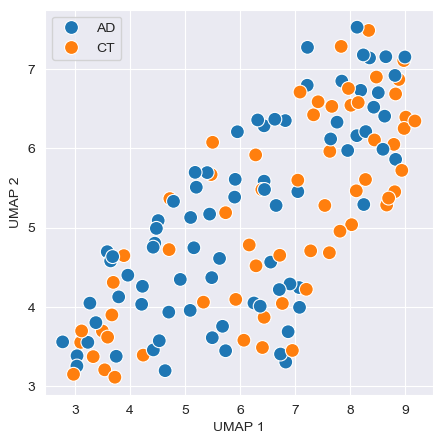

In [10]:
from umap import UMAP

umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42)
X_umap = umap.fit_transform(X)

import matplotlib.pyplot as plt
import seaborn as sns

label = ["AD" if y > 0.5 else "CT" for y in Y]

plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=label, s=100)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [11]:
N_RUNS = 100
N_FOLDS = 5
SPLIT_SEED = None
# SPLIT_SEED = 42

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

mean_accs = np.zeros(N_RUNS)
mean_prec = np.zeros(N_RUNS)
mean_rec = np.zeros(N_RUNS)
mean_f1 = np.zeros(N_RUNS)
mean_auc = np.zeros(N_RUNS)

feat_imp = np.zeros((N_RUNS, len(CELLTYPES)))
y_pred = []

for j in trange(N_RUNS):

    if SPLIT_SEED is not None:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SPLIT_SEED)
    else:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)

    test_accs = []
    test_prec = []
    test_rec = []
    test_f1 = []
    test_auc = []
    
    y_pred.append([])

    for i, (train_index, test_index) in enumerate(kf.split(X, Y)):
        
        X_train = X[train_index]
        Y_train = Y[train_index]
        
        X_test = X[test_index]
        Y_test = Y[test_index]
        
        model = Lasso(alpha=0.03)
        model.fit(X_train, Y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        test_auc.append(roc_auc_score(Y_test, y_pred_test))

        y_pred_train = (y_pred_train > 0.5).astype(int)
        y_pred_test = (y_pred_test > 0.5).astype(int)
        
        y_pred[j].append(y_pred_test)
        
        acc_train = (y_pred_train == Y_train).mean()
        acc_test = (y_pred_test == Y_test).mean()
        
        test_accs.append(accuracy_score(Y_test, y_pred_test))
        test_prec.append(precision_score(Y_test, y_pred_test))
        test_rec.append(recall_score(Y_test, y_pred_test))
        test_f1.append(f1_score(Y_test, y_pred_test))

        feat_imp[j] = model.coef_
    
    mean_accs[j] = np.mean(test_accs)
    mean_prec[j] = np.mean(test_prec)
    mean_rec[j] = np.mean(test_rec)
    mean_f1[j] = np.mean(test_f1)
    mean_auc[j] = np.mean(test_auc)
    
print(f"Mean test  acc: {np.mean(mean_accs):.4f} +/- {np.std(mean_accs):.4f}")
print(f"Mean test prec: {np.mean(mean_prec):.4f} +/- {np.std(mean_prec):.4f}")
print(f"Mean test  rec: {np.mean(mean_rec):.4f} +/- {np.std(mean_rec):.4f}")
print(f"Mean test   f1: {np.mean(mean_f1):.4f} +/- {np.std(mean_f1):.4f}")
print(f"Mean test  auc: {np.mean(mean_auc):.4f} +/- {np.std(mean_auc):.4f}")

100%|██████████| 100/100 [00:01<00:00, 52.66it/s]

Mean test  acc: 0.6389 +/- 0.0313
Mean test prec: 0.6598 +/- 0.0273
Mean test  rec: 0.7543 +/- 0.0374
Mean test   f1: 0.6990 +/- 0.0285
Mean test  auc: 0.6810 +/- 0.0289


In [16]:
# Quickly try it with a 2-layer neural network

import torch

class Net(torch.nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 1)
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.act(x)
        return x
    
def train_model(X_train, Y_train, X_test, Y_test, n_epochs=1000, lr=0.001):
    net = Net(X_train.shape[1])
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)
    
    MAX_PATIENCE = 20
    patience = 0
    best_loss = np.inf
    best_weights = None

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = net(X_train).squeeze()
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience = 0
            best_weights = net.state_dict()
        else:
            patience += 1
            if patience > MAX_PATIENCE:
                break

    net.load_state_dict(best_weights)
    
    return net

N_RUNS = 5

mean_accs = np.zeros(N_RUNS)
mean_prec = np.zeros(N_RUNS)
mean_rec = np.zeros(N_RUNS)
mean_f1 = np.zeros(N_RUNS)
mean_auc = np.zeros(N_RUNS)

for j in trange(N_RUNS):

    if SPLIT_SEED is not None:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SPLIT_SEED)
    else:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)

    test_accs = []
    test_prec = []
    test_rec = []
    test_f1 = []
    test_auc = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X, Y)):
        
        X_train = X[train_index]
        Y_train = Y[train_index]
        
        X_test = X[test_index]
        Y_test = Y[test_index]
        
        net = train_model(X_train, Y_train, X_test, Y_test)
        
        X_test = torch.tensor(X_test, dtype=torch.float32)
        Y_test = torch.tensor(Y_test, dtype=torch.float32)
        
        with torch.no_grad():
            output = net(X_test).squeeze().numpy()
        
        test_auc.append(roc_auc_score(Y_test, output))
        
        output = (output > 0.5).astype(int)
        
        test_accs.append(accuracy_score(Y_test, output))
        test_prec.append(precision_score(Y_test, output))
        test_rec.append(recall_score(Y_test, output))
        test_f1.append(f1_score(Y_test, output))
    
    mean_accs[j] = np.mean(test_accs)
    mean_prec[j] = np.mean(test_prec)
    mean_rec[j] = np.mean(test_rec)
    mean_f1[j] = np.mean(test_f1)
    mean_auc[j] = np.mean(test_auc)

print(f"Mean test  acc: {np.mean(mean_accs):.4f} +/- {np.std(mean_accs):.4f}")
print(f"Mean test prec: {np.mean(mean_prec):.4f} +/- {np.std(mean_prec):.4f}")
print(f"Mean test  rec: {np.mean(mean_rec):.4f} +/- {np.std(mean_rec):.4f}")
print(f"Mean test   f1: {np.mean(mean_f1):.4f} +/- {np.std(mean_f1):.4f}")
print(f"Mean test  auc: {np.mean(mean_auc):.4f} +/- {np.std(mean_auc):.4f}")

100%|██████████| 5/5 [00:20<00:00,  4.08s/it]

Mean test  acc: 0.5888 +/- 0.0245
Mean test prec: 0.6339 +/- 0.0222
Mean test  rec: 0.6240 +/- 0.0380
Mean test   f1: 0.6225 +/- 0.0265
Mean test  auc: 0.6012 +/- 0.0353


In [34]:
feat_imp[0]

array([-0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.02143442,
        0.        ,  0.        , -0.        , -0.06483587,  0.        ,
        0.        , -0.        ,  0.00323069,  0.        , -0.        ,
       -0.01534366,  0.0120104 , -0.00506964, -0.        ,  0.03062303,
       -0.03056121, -0.        , -0.        ,  0.06339687, -0.1314619 ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.03977736, -0.        ,  0.06791676,  0.01641856, -0.09053881,
       -0.        , -0.00545419,  0.        ,  0.        ])

## Beta weights interpretation

(all of this is from an old script, but I wanted to copy them in here just in case)

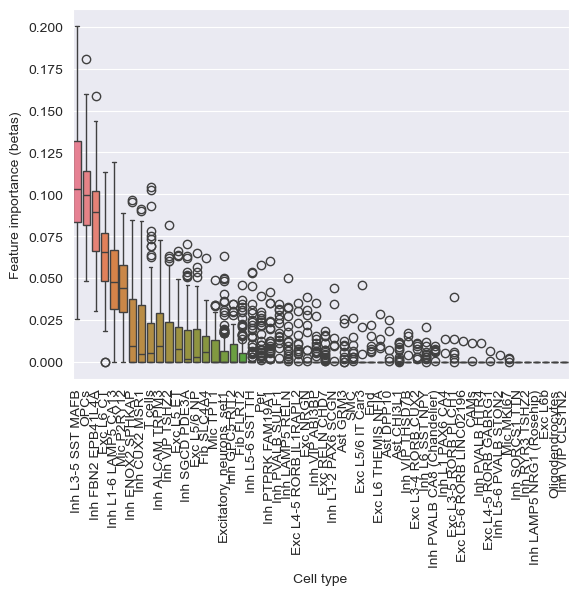

In [35]:
sort_idx = np.argsort(np.abs(feat_imp.mean(axis=0)))[::-1]

sns.boxplot(data={CELLTYPES[i]: np.abs(feat_imp[:, i]) for i in sort_idx})
plt.xticks(rotation=90)
plt.xlabel("Cell type")
plt.ylabel("Feature importance (betas)")
plt.show()

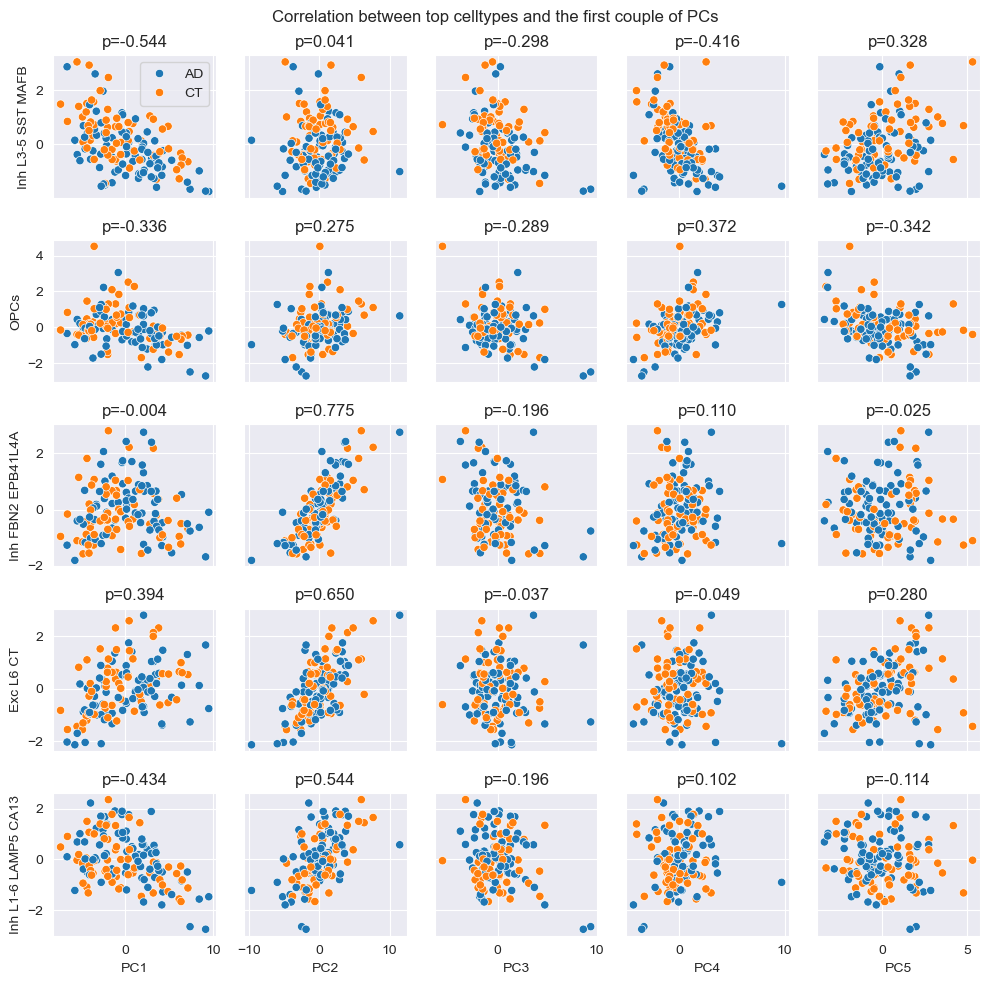

In [36]:
# Compare the correlation between the top cell types and the first couple of PCs
n_pcs = 5
n_cts = 5
fig, axs = plt.subplots(ncols=n_pcs, nrows=n_cts, figsize=(2*n_pcs, 2*n_cts), sharex="col", sharey="row")


for j in range(n_pcs):  # col
    for i in range(n_cts):  # row
        ax = axs[i, j]  # rows, cols

        ct_idx = sort_idx[i]
        ct_name = CELLTYPES[ct_idx]
        x = X_pca[:, j]
        y = X[:, ct_idx]
        
        sns.scatterplot(x=x, y=y, ax=ax, hue=adata.obs["Label"].values, legend=(i==0 and j==0))
        ax.set_title(f"p={np.corrcoef(x, y)[0, 1]:.3f}")
        
        # in-class correlation
        # corr_ct = np.corrcoef(x[Y == 0], y[Y == 0])[0, 1]
        # corr_ad = np.corrcoef(x[Y == 1], y[Y == 1])[0, 1]
        # ax.set_title(f"CT: {corr_ct:.3f}, AD: {corr_ad:.3f}")

        if j == 0:
            ax.set_ylabel(f"{ct_name}")
        if i == n_cts-1:
            ax.set_xlabel(f"PC{j+1}")

fig.suptitle("Correlation between top celltypes and the first couple of PCs")
plt.tight_layout()
plt.show()

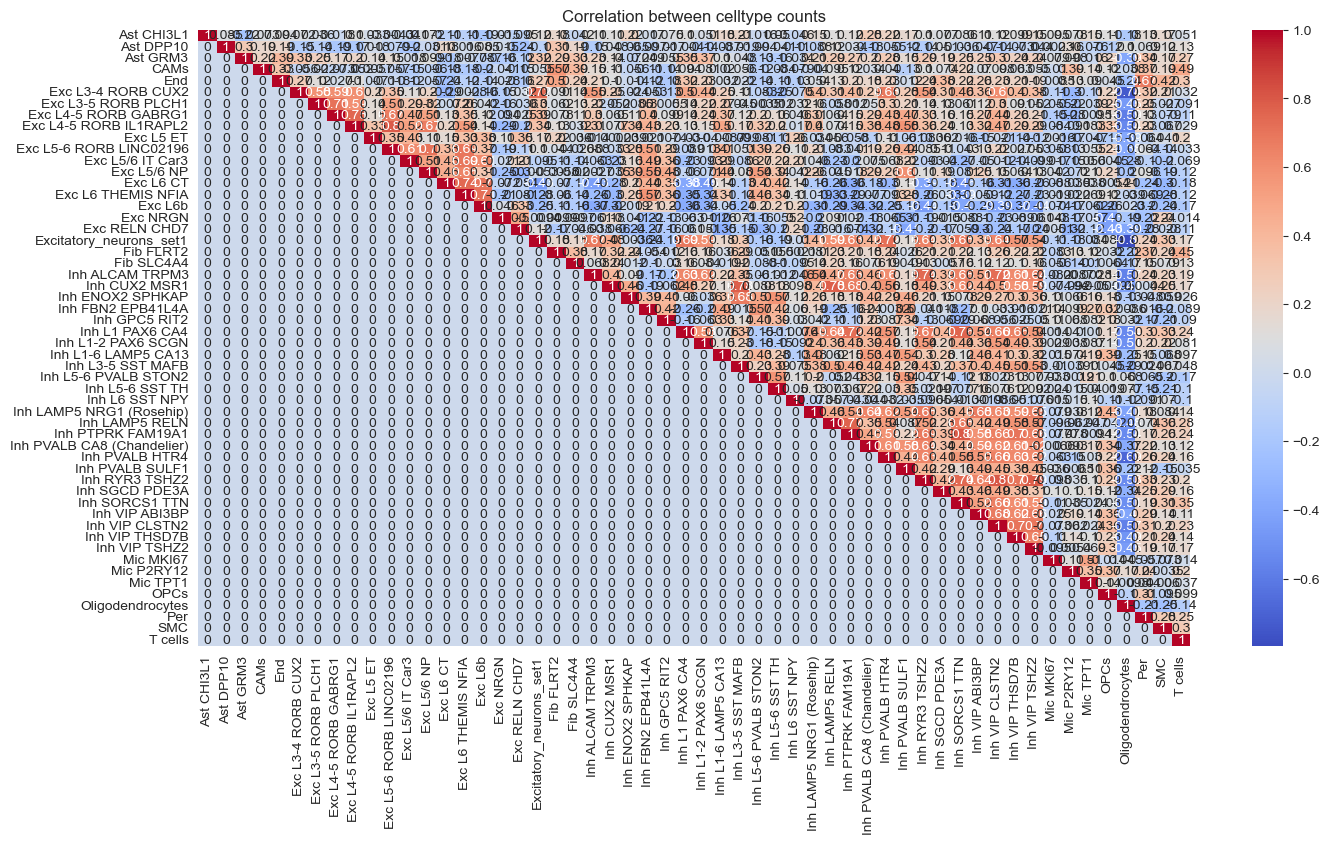

In [37]:
# compare correlations between celltype
corrs = np.zeros((len(CELLTYPES), len(CELLTYPES)))

for i, ct1 in enumerate(CELLTYPES):
    for j, ct2 in enumerate(CELLTYPES):
        if i <= j:
            corrs[i, j] = np.corrcoef(X[:, i], X[:, j])[0, 1]

plt.figure(figsize=(16, 8))
sns.heatmap(corrs, annot=True, xticklabels=CELLTYPES, yticklabels=CELLTYPES, cmap="coolwarm")
plt.title("Correlation between celltype counts")
plt.show()